In [1]:
!echo "Last updated: `date`"

Last updated: Tue Aug  4 15:44:30 PDT 2020


In [2]:
# Libraries
import json
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS, HMC
import torch
import torch.distributions.constraints as constraints
from torch.nn.functional import pad
from tqdm import trange

# For ADVI
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam

# For GP
import pyro.contrib.gp as gp

import sys
sys.path.append('../util')
import gp_plot_util

# See:
# http://docs.pyro.ai/en/stable/contrib.gp.html
# https://pyro.ai/examples/gp.html

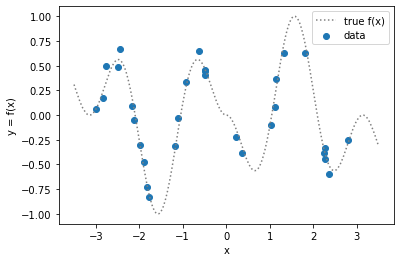

In [3]:
# Read data.
path_to_data = '../data/gp-data-N30.json'
simdata = json.load(open(path_to_data))

# Store data as torch.tensors.
X = torch.tensor(simdata['x']).reshape(-1, 1)
y = torch.tensor(simdata['y'])
x_grid = torch.tensor(simdata['x_grid'])
f = torch.tensor(simdata['f'])

# Plot data and true function.
plt.scatter(X, y, label='data')
plt.plot(x_grid, f, ls=':', c='grey', label='true f(x)')
plt.xlabel('x')
plt.ylabel('y = f(x)')
plt.legend();

In [4]:
def make_gp_model(X, y,
                  length_prior=dist.LogNormal(0.0, 1.0),
                  variance_prior=dist.LogNormal(0.0, 0.1),
                  noise_prior=dist.LogNormal(0.0, 1.0)):
    
    # Define squared exponential covariance function.
    cov_fn = gp.kernels.RBF(input_dim=1)

    # Define GP regression model.
    gpr = gp.models.GPRegression(X, y, cov_fn)

    # Place priors on GP covariance function parameters.
    gpr.kernel.lengthscale = pyro.nn.PyroSample(length_prior)
    gpr.kernel.variance = pyro.nn.PyroSample(variance_prior)
    gpr.noise = pyro.nn.PyroSample(noise_prior)
    
    return gpr

In [5]:
%%time

### HMC ###
pyro.clear_param_store()

# Set random seed for reproducibility.
pyro.set_rng_seed(1)

# Make GP model for HMC
hmc_gpr = make_gp_model(X, y)

# Set up HMC sampler.
kernel = HMC(hmc_gpr.model, step_size=0.01, trajectory_length=1, target_accept_prob=0.8,
             adapt_step_size=False, adapt_mass_matrix=False)
hmc = MCMC(kernel, num_samples=1000, warmup_steps=1000)
hmc.run()

# Get posterior samples
hmc_posterior_samples = hmc.get_samples()
hmc_posterior_samples = dict(rho=hmc_posterior_samples['kernel.lengthscale'].numpy(),
                             alpha=hmc_posterior_samples['kernel.variance'].sqrt().numpy(),
                             sigma=hmc_posterior_samples['noise'].sqrt().numpy())

Sample: 100%|██████████| 2000/2000 [09:39,  3.45it/s, step size=1.00e-02, acc. prob=0.999]

CPU times: user 28min 55s, sys: 5.91 s, total: 29min 1s
Wall time: 9min 39s


In [6]:
%%time

### NUTS ###
pyro.clear_param_store()

# Set random seed for reproducibility.
pyro.set_rng_seed(1)

# Make GP model for NUTS
nuts_gpr = make_gp_model(X, y)

# Set up NUTS sampler.
kernel = NUTS(nuts_gpr.model, target_accept_prob=0.8)
nuts = MCMC(kernel, num_samples=1000, warmup_steps=1000)
%time nuts.run()

# Get posterior samples
nuts_posterior_samples = nuts.get_samples()
nuts_posterior_samples = dict(rho=nuts_posterior_samples['kernel.lengthscale'].numpy(),
                              alpha=nuts_posterior_samples['kernel.variance'].sqrt().numpy(),
                              sigma=nuts_posterior_samples['noise'].sqrt().numpy())

Sample: 100%|██████████| 2000/2000 [00:35, 56.01it/s, step size=6.78e-01, acc. prob=0.925]

CPU times: user 1min 46s, sys: 366 ms, total: 1min 47s
Wall time: 35.7 s
CPU times: user 1min 46s, sys: 369 ms, total: 1min 47s
Wall time: 35.7 s


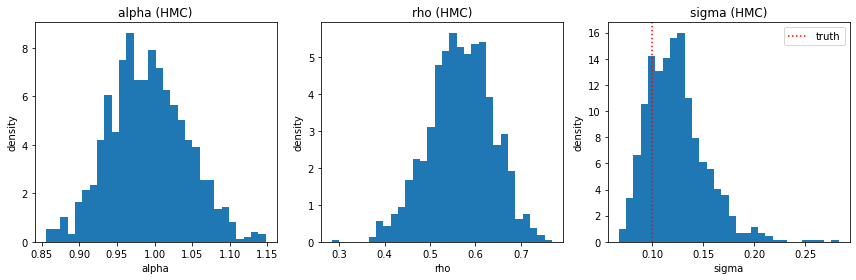

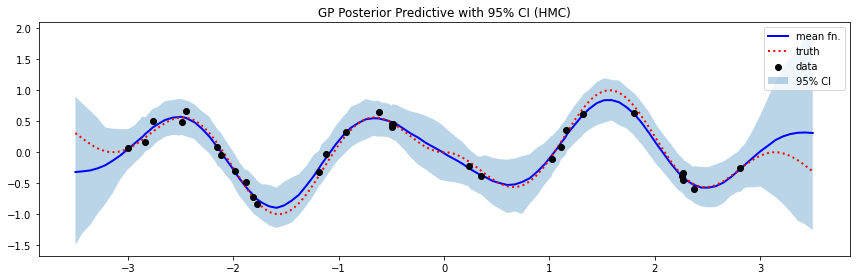

In [7]:
# Plot posterior for HMC
gp_plot_util.make_plots(hmc_posterior_samples, suffix="HMC",
                        x=X.flatten(), y=y, x_grid=x_grid, f=f, sigma_true=simdata['sigma'])

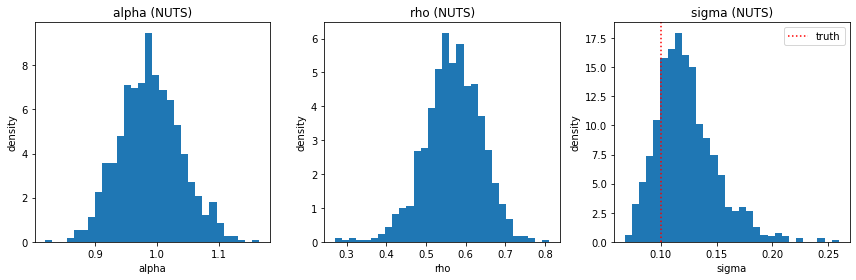

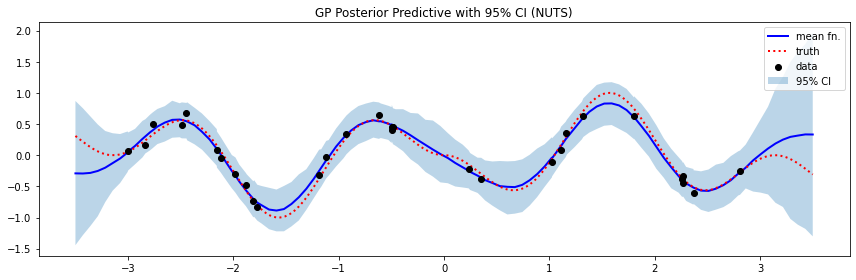

In [8]:
# Plot posterior for NUTS
gp_plot_util.make_plots(nuts_posterior_samples, suffix="NUTS",
                        x=X.flatten(), y=y, x_grid=x_grid, f=f, sigma_true=simdata['sigma'])

100%|██████████| 500/500 [00:01<00:00, 292.87it/s]


CPU times: user 5.12 s, sys: 32 ms, total: 5.15 s
Wall time: 1.72 s


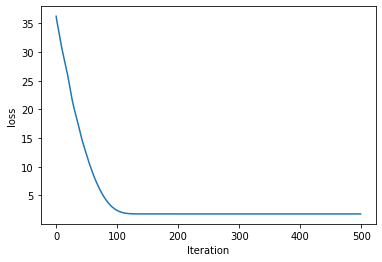

In [9]:
%%time

### MAP ###
# Can't get posterior samples for ADVI?

# Clear parameter cache.
pyro.clear_param_store()

# Set random seed for reproducibility.
pyro.set_rng_seed(3)

# Make GP model for MAP
map_gpr = make_gp_model(X, y)

# Find MAP estimator
optimizer = torch.optim.Adam(map_gpr.parameters(), lr=5e-2)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 500
for i in trange(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(map_gpr.model, map_gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
# Plot loss
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("loss");

# This 
map_gpr.set_mode('guide')
map_samples = dict(alpha=[map_gpr.kernel.variance.sqrt().item() for _ in range(10)],
                   rho=[map_gpr.kernel.lengthscale.item() for _ in range(10)],
                   sigma=[map_gpr.noise.sqrt().item() for _ in range(10)])

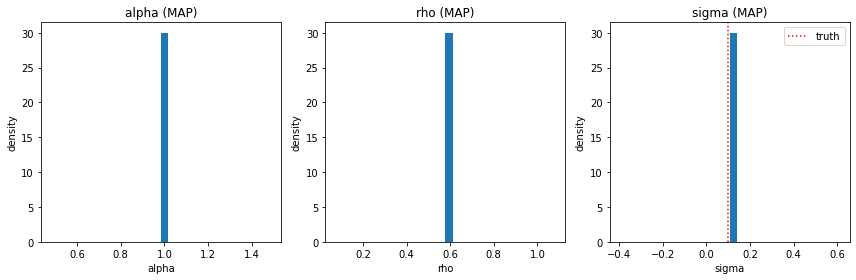

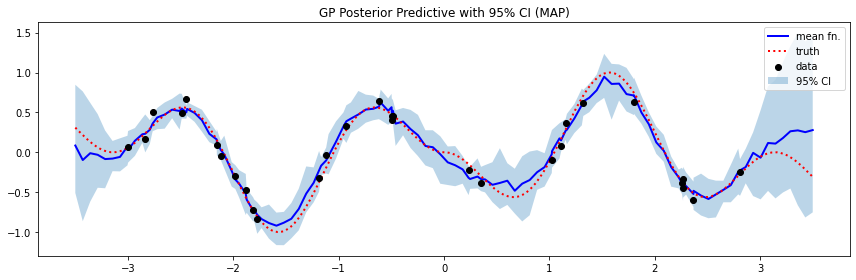

In [10]:
# Plot posterior for MAP
gp_plot_util.make_plots(map_samples, suffix="MAP",
                        x=X.flatten(), y=y, x_grid=x_grid, f=f, sigma_true=simdata['sigma'])